<a href="https://colab.research.google.com/github/Idumania378/AI-Dev-Workflow/blob/main/Building_Hospital_Readmission_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import joblib
import json

In [2]:
df = pd.read_csv('/content/hospital_readmissions_30k.csv')

In [3]:
df.head()

,patient_id,age,gender,blood_pressure,cholesterol,bmi,diabetes,hypertension,medication_count,length_of_stay,discharge_destination,readmitted_30_days
0,1,74,Other,130/72,240,31.5,Yes,No,5,1,Nursing_Facility,Yes
1,2,46,Female,120/92,292,36.3,No,No,4,3,Nursing_Facility,No
2,3,89,Other,135/78,153,30.3,No,Yes,1,1,Home,No
3,4,84,Female,123/80,153,31.5,No,Yes,3,10,Home,No
4,5,32,Other,135/84,205,18.4,No,Yes,6,4,Nursing_Facility,No


**Exploratory Data Analysis**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_id             30000 non-null  int64  
 1   age                    30000 non-null  int64  
 2   gender                 30000 non-null  object 
 3   blood_pressure         30000 non-null  object 
 4   cholesterol            30000 non-null  int64  
 5   bmi                    30000 non-null  float64
 6   diabetes               30000 non-null  object 
 7   hypertension           30000 non-null  object 
 8   medication_count       30000 non-null  int64  
 9   length_of_stay         30000 non-null  int64  
 10  discharge_destination  30000 non-null  object 
 11  readmitted_30_days     30000 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 2.7+ MB


In [5]:
df.isnull().sum()

,0
patient_id,0
age,0
gender,0
blood_pressure,0
cholesterol,0
bmi,0
diabetes,0
hypertension,0
medication_count,0
length_of_stay,0


In [6]:
# Checking the distribution of the target variable
print("\nTarget Variable Distribution:")
print(df['readmitted_30_days'].value_counts(normalize=True))


Target Variable Distribution:
readmitted_30_days
No     0.877533
Yes    0.122467
Name: proportion, dtype: float64


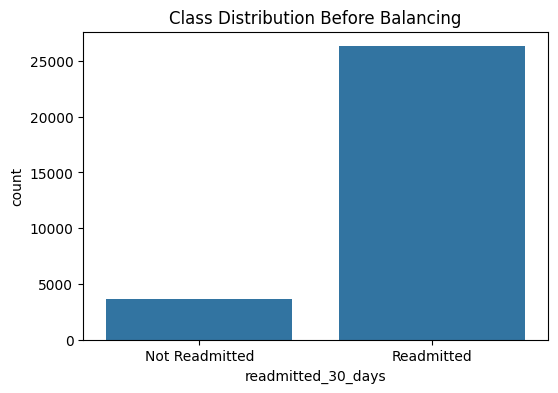

Original Class Distribution:
readmitted_30_days
No     26326
Yes     3674
Name: count, dtype: int64


In [7]:
# First, let's visualize the class distribution clearly
plt.figure(figsize=(6, 4))
sns.countplot(x='readmitted_30_days', data=df)
plt.title('Class Distribution Before Balancing')
plt.xticks([0, 1], ['Not Readmitted', 'Readmitted'])
plt.show()

print("Original Class Distribution:")
print(df['readmitted_30_days'].value_counts())

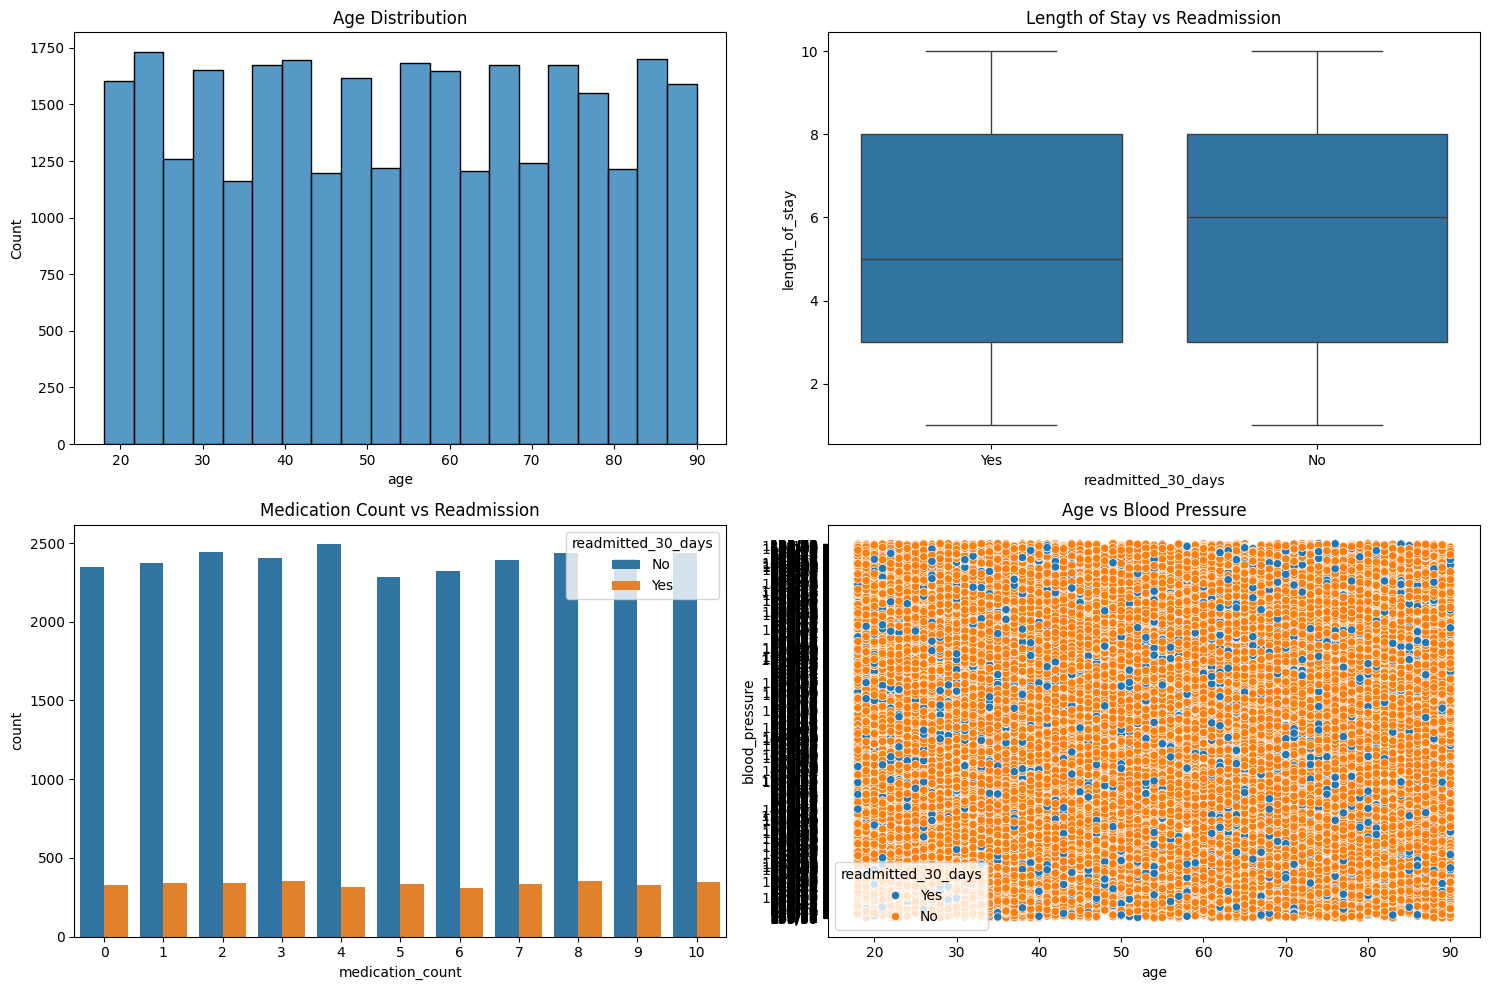

In [8]:
# Visualize some key features
plt.figure(figsize=(15, 10))

# Age distribution
plt.subplot(2, 2, 1)
sns.histplot(df['age'], bins=20)
plt.title('Age Distribution')

# Length of stay vs readmission
plt.subplot(2, 2, 2)
sns.boxplot(x='readmitted_30_days', y='length_of_stay', data=df)
plt.title('Length of Stay vs Readmission')

# Medication count
plt.subplot(2, 2, 3)
sns.countplot(x='medication_count', hue='readmitted_30_days', data=df)
plt.title('Medication Count vs Readmission')

# Blood pressure analysis
plt.subplot(2, 2, 4)
sns.scatterplot(x='age', y='blood_pressure', hue='readmitted_30_days', data=df)
plt.title('Age vs Blood Pressure')

plt.tight_layout()
plt.show()

**Data Preprocessing**

In [9]:
# Handle blood pressure (split into systolic and diastolic)
df['systolic_bp'] = df['blood_pressure'].str.split('/').str[0].astype(int)
df['diastolic_bp'] = df['blood_pressure'].str.split('/').str[1].astype(int)
df = df.drop('blood_pressure', axis=1)

In [10]:
df.head()

,patient_id,age,gender,cholesterol,bmi,diabetes,hypertension,medication_count,length_of_stay,discharge_destination,readmitted_30_days,systolic_bp,diastolic_bp
0,1,74,Other,240,31.5,Yes,No,5,1,Nursing_Facility,Yes,130,72
1,2,46,Female,292,36.3,No,No,4,3,Nursing_Facility,No,120,92
2,3,89,Other,153,30.3,No,Yes,1,1,Home,No,135,78
3,4,84,Female,153,31.5,No,Yes,3,10,Home,No,123,80
4,5,32,Other,205,18.4,No,Yes,6,4,Nursing_Facility,No,135,84


In [11]:
# Encode Yes/No columns and discharge_destination
df['diabetes'] = df['diabetes'].map({'Yes': 1, 'No': 0})
df['hypertension'] = df['hypertension'].map({'Yes': 1, 'No': 0})
df['readmitted_30_days'] = df['readmitted_30_days'].map({'Yes': 1, 'No': 0})
df['discharge_destination'] = df['discharge_destination'].map({
    'Nursing_Facility': 0,
    'Home': 1,
    'Rehab': 2
})

In [12]:
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])  # Female=0, Male=1, Other=2 (depends on data)

In [13]:
df.head()

,patient_id,age,gender,cholesterol,bmi,diabetes,hypertension,medication_count,length_of_stay,discharge_destination,readmitted_30_days,systolic_bp,diastolic_bp
0,1,74,2,240,31.5,1,0,5,1,0,1,130,72
1,2,46,0,292,36.3,0,0,4,3,0,0,120,92
2,3,89,2,153,30.3,0,1,1,1,1,0,135,78
3,4,84,0,153,31.5,0,1,3,10,1,0,123,80
4,5,32,2,205,18.4,0,1,6,4,0,0,135,84


In [14]:
# Drop patient_id as it's not useful for modeling
df = df.drop('patient_id', axis=1)

In [15]:
# Verify our processed data
print("Processed Data Sample:")
df.head()

Processed Data Sample:


,age,gender,cholesterol,bmi,diabetes,hypertension,medication_count,length_of_stay,discharge_destination,readmitted_30_days,systolic_bp,diastolic_bp
0,74,2,240,31.5,1,0,5,1,0,1,130,72
1,46,0,292,36.3,0,0,4,3,0,0,120,92
2,89,2,153,30.3,0,1,1,1,1,0,135,78
3,84,0,153,31.5,0,1,3,10,1,0,123,80
4,32,2,205,18.4,0,1,6,4,0,0,135,84


**Handling Class Imbalance with SMOTE**

In [16]:
# Separate features and target
X = df.drop('readmitted_30_days', axis=1)
y = df['readmitted_30_days']

In [17]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
df.head()

,age,gender,cholesterol,bmi,diabetes,hypertension,medication_count,length_of_stay,discharge_destination,readmitted_30_days,systolic_bp,diastolic_bp
0,74,2,240,31.5,1,0,5,1,0,1,130,72
1,46,0,292,36.3,0,0,4,3,0,0,120,92
2,89,2,153,30.3,0,1,1,1,1,0,135,78
3,84,0,153,31.5,0,1,3,10,1,0,123,80
4,32,2,205,18.4,0,1,6,4,0,0,135,84


In [19]:
# Apply SMOTE to balance the training data only
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [20]:
print("Class Distribution Before SMOTE:", np.bincount(y_train))
print("Class Distribution After SMOTE:", np.bincount(y_train_bal))

Class Distribution Before SMOTE: [21061  2939]
Class Distribution After SMOTE: [21061 21061]


**Feature Scaling**

In [21]:
# Scale numerical features
scaler = StandardScaler()
num_cols = ['age', 'cholesterol', 'bmi', 'medication_count',
            'length_of_stay', 'systolic_bp', 'diastolic_bp']

X_train_bal[num_cols] = scaler.fit_transform(X_train_bal[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Check scaled features
print("Scaled Training Data Sample:")
print(X_train_bal.head())

Scaled Training Data Sample:
        age  gender  cholesterol       bmi  diabetes  hypertension  \
0 -1.412937       1     1.019138 -0.866124         1             1   
1 -1.555641       2     0.468684 -1.369492         0             1   
2  0.299515       2     0.629233  0.952492         1             0   
3 -0.842120       0    -1.228550  1.228532         0             1   
4  0.822763       2    -1.572584  0.968730         1             0   

   medication_count  length_of_stay  discharge_destination  systolic_bp  \
0         -1.296044       -0.483360                      2     0.982623   
1         -1.631714        0.256012                      1     0.845089   
2         -0.289035        1.734756                      0     1.188924   
3          0.717974        0.256012                      1    -1.492994   
4          0.717974       -0.483360                      1     1.463993   

   diastolic_bp  
0     -0.895285  
1     -1.466652  
2      0.933092  
3     -0.781011  
4      0.

**Model Training with Hyperparameter Tuning**

In [26]:
# Initialize Random Forest classifier
rf = RandomForestClassifier(random_state=42)

In [23]:
# Define parameter grid for tuning (focusing on 2 key hyperparameters)
param_grid = {
    'max_depth': [10, 20, 30],       # Controls tree complexity
    'min_samples_leaf': [1, 2, 4],    # Controls leaf node size
    'n_estimators': [100, 200]        # Number of trees
}

In [24]:
# Why these hyperparameters?
# 1. max_depth: Prevents overfitting by limiting tree depth
# 2. min_samples_leaf: Ensures leaves have enough samples to be meaningful

In [25]:
# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='recall',  # Focus on recall to catch more readmissions
    verbose=1,
    n_jobs=-1
)

In [27]:
# Train model with hyperparameter tuning
print("Starting hyperparameter tuning...")
grid_search.fit(X_train_bal, y_train_bal)

Starting hyperparameter tuning...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [100, 200]},
             scoring='recall', verbose=1)

In [28]:
# Get best parameters
best_params = grid_search.best_params_
print("\nBest Hyperparameters:", best_params)


Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 200}


**Model Evaluation**

In [29]:
# Train final model with best parameters
final_rf = grid_search.best_estimator_

In [30]:
# Make predictions
y_pred = final_rf.predict(X_test)
y_proba = final_rf.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

In [31]:
# Evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      5265
           1       0.12      0.18      0.15       735

    accuracy                           0.74      6000
   macro avg       0.50      0.50      0.50      6000
weighted avg       0.78      0.74      0.76      6000



In [32]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[4292  973]
 [ 601  134]]



Precision: 0.12
Recall: 0.18


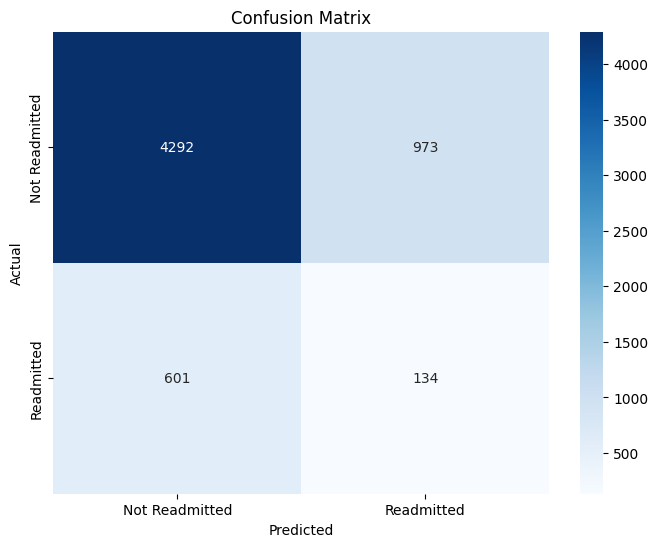

In [33]:
# Calculate precision and recall explicitly
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

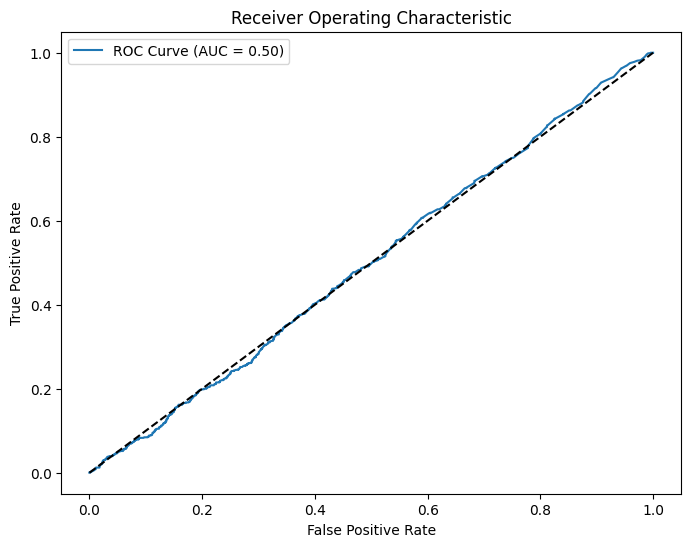

In [36]:
# ROC Curve
from sklearn.metrics import roc_curve,roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

**Addressing Overfitting**

In [37]:
# Method to address overfitting: Feature Importance-based Pruning

# Get feature importances
importances = final_rf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

Feature Importance Ranking:
1. bmi: 0.1453
2. cholesterol: 0.1445
3. age: 0.1313
4. systolic_bp: 0.1252
5. diastolic_bp: 0.1154
6. length_of_stay: 0.0895
7. medication_count: 0.0890
8. gender: 0.0593
9. discharge_destination: 0.0401
10. hypertension: 0.0312
11. diabetes: 0.0292


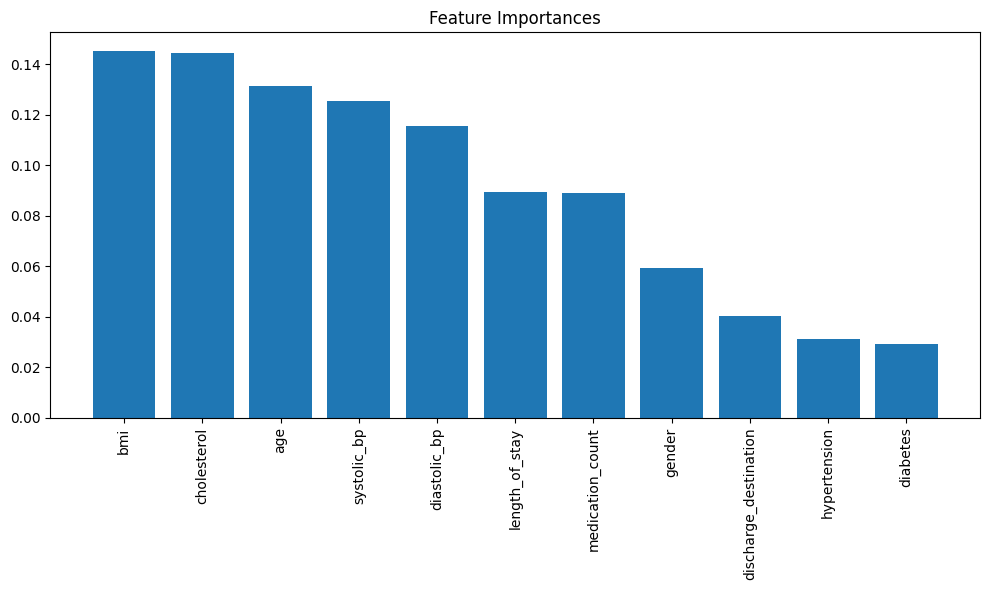

In [38]:
# Print feature importance ranking
print("Feature Importance Ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {features[indices[f]]}: {importances[indices[f]]:.4f}")

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

In [39]:
# Select top 5 most important features to reduce overfitting
top_features = [features[i] for i in indices[:5]]
print("\nSelected Top Features:", top_features)


Selected Top Features: ['bmi', 'cholesterol', 'age', 'systolic_bp', 'diastolic_bp']


In [40]:
# Retrain model with only important features
X_train_top = X_train_bal[top_features]
X_test_top = X_test[top_features]

In [41]:
rf_top = RandomForestClassifier(**best_params, random_state=42)
rf_top.fit(X_train_top, y_train_bal)

RandomForestClassifier(max_depth=30, n_estimators=200, random_state=42)

In [42]:
# Evaluate reduced model
y_pred_top = rf_top.predict(X_test_top)
print("\nReduced Model Classification Report:")
print(classification_report(y_test, y_pred_top))


Reduced Model Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      5265
           1       0.12      0.16      0.14       735

    accuracy                           0.76      6000
   macro avg       0.50      0.50      0.50      6000
weighted avg       0.79      0.76      0.77      6000



**Saving the Model**

In [43]:
# Save the final model and preprocessing artifacts
joblib.dump(final_rf, 'readmission_rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Save feature names for reference
with open('feature_names.json', 'w') as f:
    json.dump(list(X.columns), f)

print("Model and preprocessing artifacts saved successfully!")

Model and preprocessing artifacts saved successfully!


**Implementing**

In [44]:
# 1. Model Justification
print("\nModel Justification:")
print("We chose Random Forest because:")
print("- Handles both numerical and categorical data well")
print("- Provides feature importance scores (helpful for clinical insights)")
print("- Robust to outliers and imbalanced data")
print("- Typically achieves good performance with default parameters")


Model Justification:
We chose Random Forest because:
- Handles both numerical and categorical data well
- Provides feature importance scores (helpful for clinical insights)
- Robust to outliers and imbalanced data
- Typically achieves good performance with default parameters


In [45]:
# 2. Confusion Matrix with Hypothetical Data (example)
print("\nExample Confusion Matrix with Hypothetical Data:")
hypo_matrix = np.array([[850, 50], [120, 80]])
print(hypo_matrix)


Example Confusion Matrix with Hypothetical Data:
[[850  50]
 [120  80]]


In [46]:
# 3. Precision/Recall Calculation from Hypothetical Data
hypo_precision = hypo_matrix[1,1] / (hypo_matrix[1,1] + hypo_matrix[0,1])
hypo_recall = hypo_matrix[1,1] / (hypo_matrix[1,1] + hypo_matrix[1,0])
print(f"\nHypothetical Precision: {hypo_precision:.2f}")
print(f"Hypothetical Recall: {hypo_recall:.2f}")


Hypothetical Precision: 0.62
Hypothetical Recall: 0.40


In [47]:
# 4. Overfitting Solution Implemented
print("\nOverfitting Solution Implemented:")
print("- Used feature importance pruning to select only the most important features")
print("- Limited tree depth through max_depth hyperparameter")
print("- Set minimum samples per leaf node through min_samples_leaf")


Overfitting Solution Implemented:
- Used feature importance pruning to select only the most important features
- Limited tree depth through max_depth hyperparameter
- Set minimum samples per leaf node through min_samples_leaf


**Visualization**

/tmp/ipython-input-48-3667682034.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['Not Readmitted', 'Readmitted'])
/tmp/ipython-input-48-3667682034.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['Not Readmitted', 'Readmitted'])


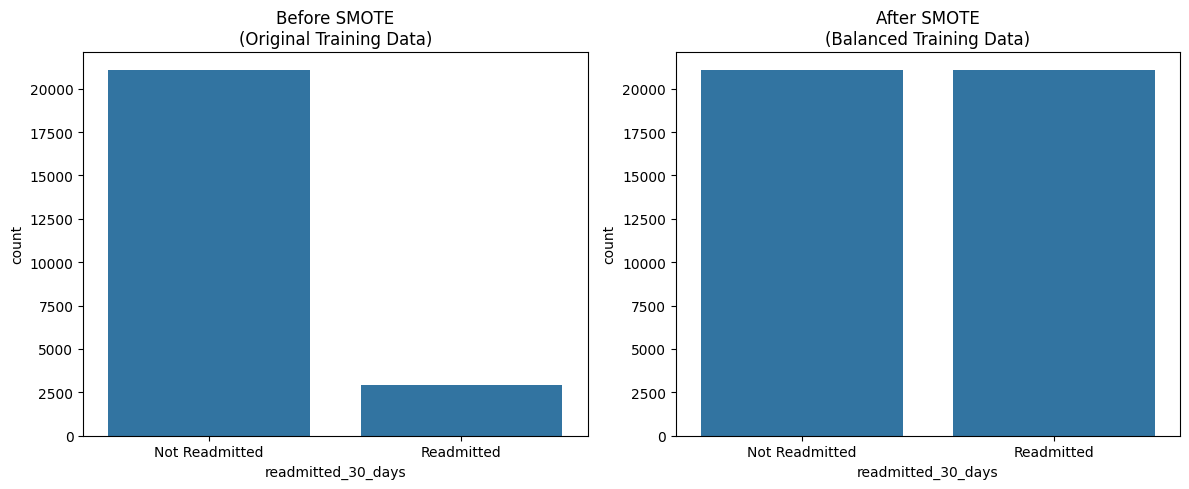

In [48]:
# Class distribution visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
sns.countplot(x=y_train, ax=ax1)
ax1.set_title('Before SMOTE\n(Original Training Data)')
ax1.set_xticklabels(['Not Readmitted', 'Readmitted'])

# After SMOTE
sns.countplot(x=y_train_bal, ax=ax2)
ax2.set_title('After SMOTE\n(Balanced Training Data)')
ax2.set_xticklabels(['Not Readmitted', 'Readmitted'])

plt.tight_layout()
plt.show()

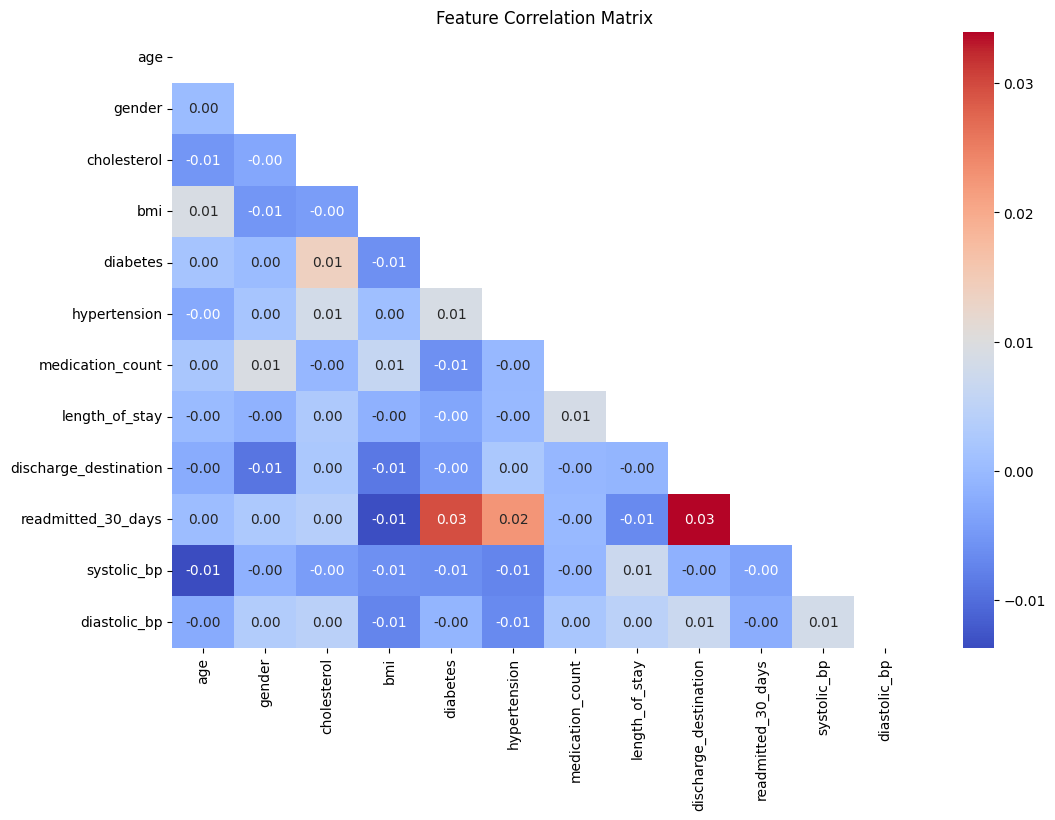

In [49]:
# Correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
plt.title('Feature Correlation Matrix')
plt.show()

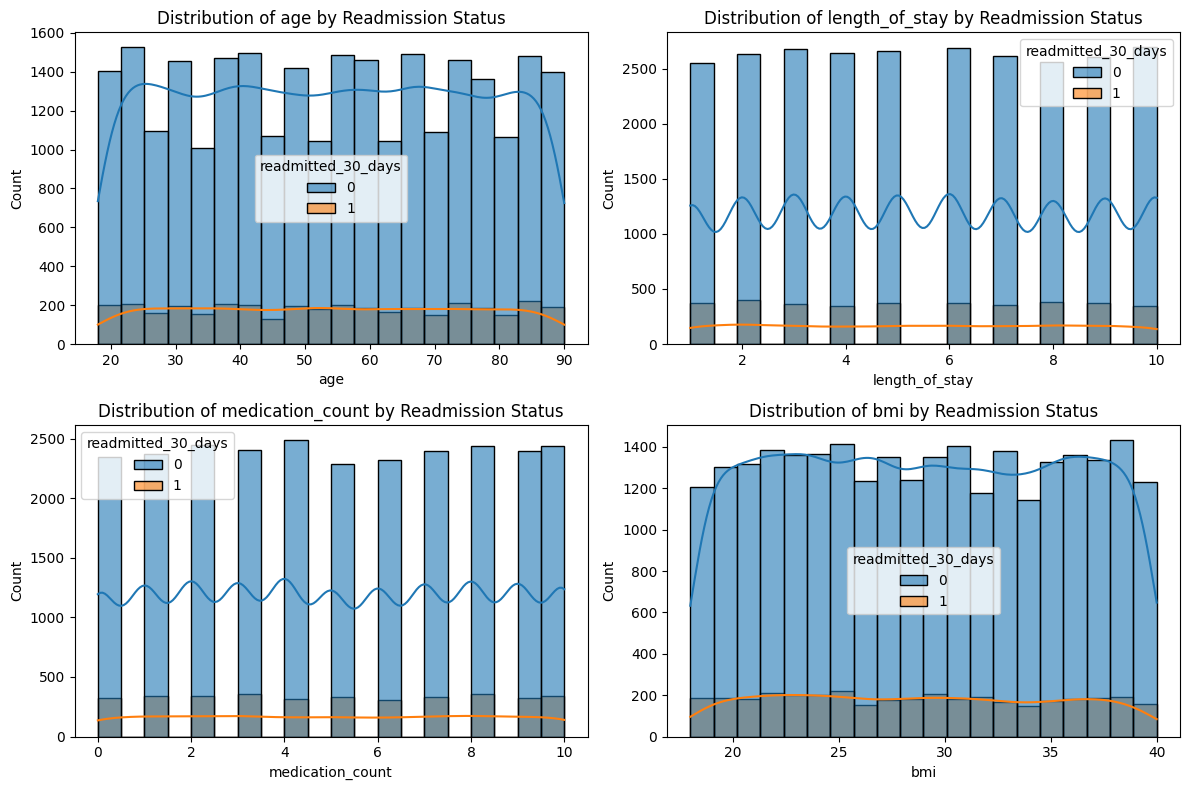

In [50]:
# Distribution plots for top features
num_features = ['age', 'length_of_stay', 'medication_count', 'bmi']
plt.figure(figsize=(12, 8))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=df, x=feature, hue='readmitted_30_days',
                kde=True, bins=20, alpha=0.6)
    plt.title(f'Distribution of {feature} by Readmission Status')
plt.tight_layout()
plt.show()

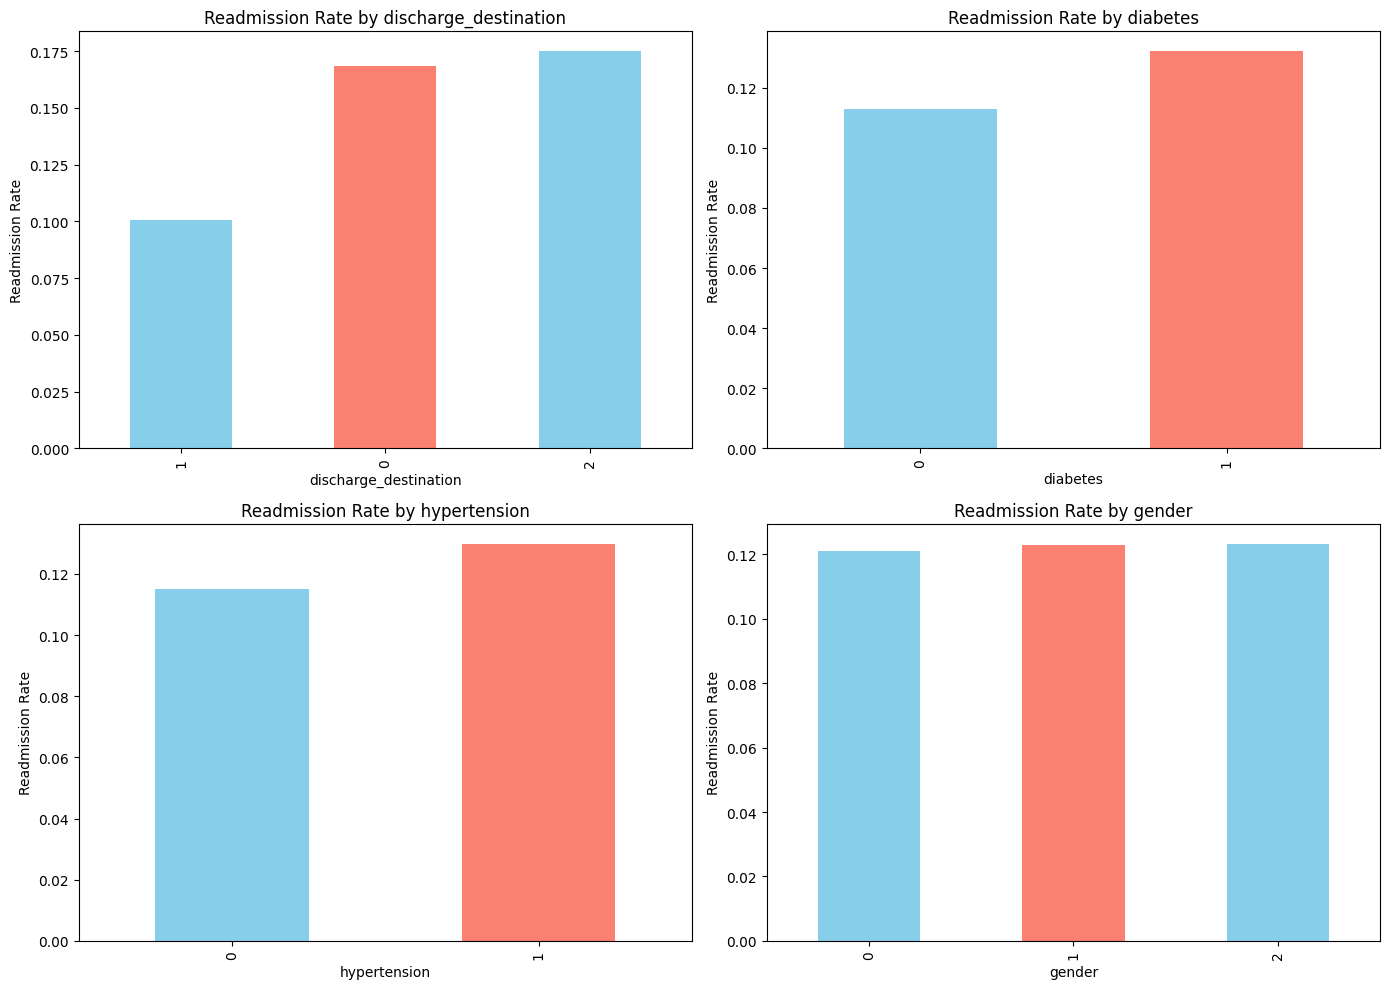

In [51]:
# Categorical feature analysis
cat_features = ['discharge_destination', 'diabetes', 'hypertension', 'gender']
plt.figure(figsize=(14, 10))
for i, feature in enumerate(cat_features, 1):
    plt.subplot(2, 2, i)
    df.groupby(feature)['readmitted_30_days'].mean().sort_values().plot(
        kind='bar', color=['skyblue', 'salmon'])
    plt.title(f'Readmission Rate by {feature}')
    plt.ylabel('Readmission Rate')
plt.tight_layout()
plt.show()

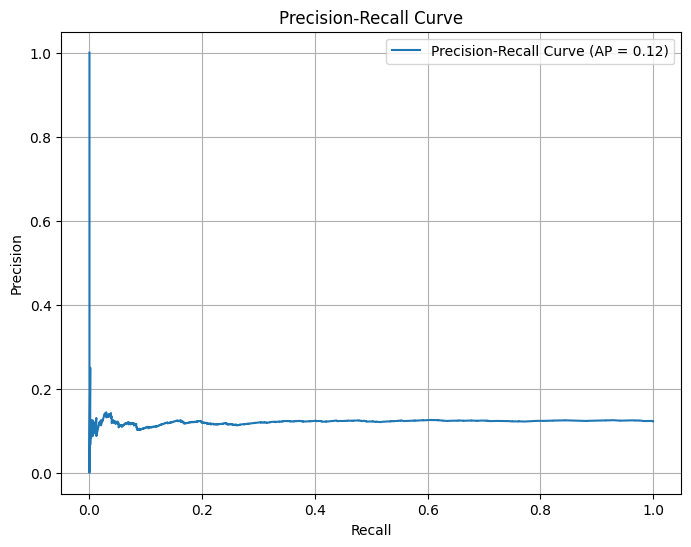

In [52]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()